# Stellar spectra    A. Basic Line Formation  


**Jakob Borg**

***Instructions*** *This is the template for submitting SSA. Please update your name or student identifier above. Before you submit, make sure you delete all the markdown cells with text in italic (such as these instructions). Do not delete the questions themselves. Write your answers in the cells below the questions. While only one empty cell appears before the question blocks, feel free to add any quantity of cells (code or Markdown) in the order and quantity you see fit. You can also modify the header below to suit your needs, but please don't use any non-standard packages and do not load external code. The whole notebook must run without any errors in the code. In this first experiment with notebooks, there are no page / text limits. But please write concisely, and try to keep it short!*

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)

## 1. Saha-Boltzmann calibration of the Harvard sequence ("Cecilia Payne")

## 1.1 Payne’s line strength diagram

## 1.2 The Boltzmann and Saha laws

* Inspect the hydrogen energy level diagram in section 1.2. Which transitions correspond to the hydrogen lines in the image with stellar spectrograms (section 1)? Which transitions share lower levels and which share upper levels?

* Payne's basic assumption was that the strength of the absorption lines observed in stellar spectra scales with the population density of the lower level of the corresponding transition. Why would she think so? (It is not correct, but generally stellar absorption lines do get stronger at larger lower-level population. In this exercise we follow her example and assume that the scaling is linear.)

* Use this expectation to give initial rough estimates of the strength ratios of the $\alpha$ lines in the the H I Lyman, Balmer, Paschen and Brackett series.


*Answers*
  * We can see that the different hydrogen-lines from the stellar spectrograms lie between other lines with noted wavelengths. That is:
    * $H\delta \in [4026, 4227]Å$
    * $H\gamma \in [4227, 4472]Å$
    * $H\beta \in [4472,4954]Å$
    
  With the energy level diagram we can conclude that all of these transitions belong in the Balmer series. As the wavelengths lie in the $\sim 400$ nm range. This is consistent with the fact that we know that transitions in the Balmer series emit light in the visible spectrum. This means that all the threee transitions share lower level, $s=s$, but non share upper (as they then would produce the same wavelength).
  
  * Her assumption is understandable. With a high population density in a specific level, say A, one would think that many transitions from higher levels down to level A has allready occured. Thus a lot of photons of wavelengths accosiated with level A would have been emitted and we see a high intensity.
  
  * With Payne's expectation, we can give estimates of the ratio of the strength of different spectral lines by looking at the ratio of population density from the Boltzmann law. By looking at the ratio of lines from the same ionization level we can cancel out the normalization term and the partition function.  
  We write the ratio as  
  $\frac{n_{r,s}}{n_{r,t}} = \frac{g_{r,s}e^{-\chi_{r,s}/kT}}{g_{r,t}e^{-\chi_{r,t}/kT}} \overset{r=1}{=} \frac{s^2}{t^2} e^{ (\chi_{1,t}-\chi_{1,s})/kT }$  
  Where we used that the degeneracy of nuetral hydrogen is $g_{1,s} = 2s^2$. The energy levels is defined as $\chi_{1,s} = 13.598(1-s^{-2})$eV, and so we can calculate the ratios and plot them against energy levels. Here we have used the Lyman alpha line ($s=1$) as the base for the ratios, at temperature $T=5800$K.

[1.00000000e+00 2.02196117e+08 4.01041171e+09 8.52454132e+09]


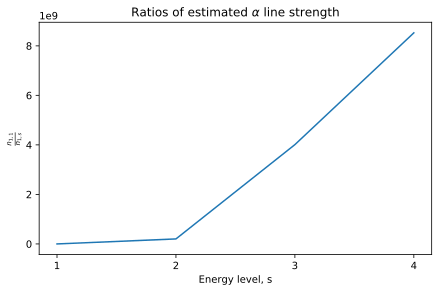

In [45]:
ss = np.arange(1,5,1,dtype=float)
k = constants.k_B
T = 5.77e3*units.K

chi = 13.598*(1-ss**(-2))*units.eV

# Ratio comparing strengths to the Lyman alpha strength, at temperature 1000K
ratios = (1/ss)**2*np.exp((chi-chi[0])/(k*T))
print(ratios)
plt.plot(ss,ratios)
plt.title(r'Ratios of estimated $\alpha$ line strength')
plt.xticks(ss)
plt.xlabel('Energy level, s')
plt.ylabel(r'$\frac{n_{1,1}}{n_{1,s}}$');

* Explain from equations (1) and (3) why the Saha and Boltzmann distributions behave differently for increasing temperature.
* Speculate how ionisation can fully deplete a stage while excitation puts only a few atoms in levels just below the ionisation level. Hint: what is the limit of the Saha and Boltzman ratios for infinite temperature?

*Answers*

  * The Boltzmann distribution's temperature dependence is only in the exponential term, which for increasing temperature just tends towards 1, $e^{-1/T} \overset{T\rightarrow \infty}{=} 1$.
  
  The Saha distribution also have a power law dependence on the temperature in addition to the exponential. While the exponential term tends towards 1 again for increasing temperature, the $T^{3/2} \rightarrow \infty$.
  
  * 

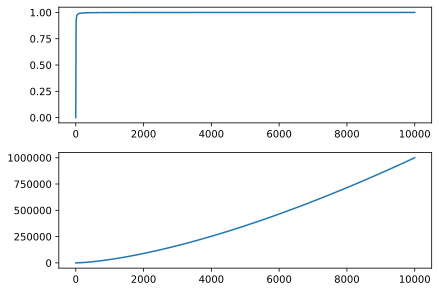

In [54]:
t = np.linspace(1e-4,1e4,1000)
fig,ax = plt.subplots(2,1)

ax[0].plot(t,np.exp(-1/t))
ax[1].plot(t,t**(3/2)*np.exp(-1/t));

## 1.3 Saha-Boltzmann populations of a simplified Ca atom

### 1.3.1 Partition function 

### 1.3.2 Compute the level populations according to the Boltzmann law

### 1.3.3 Compute the ionisation fractions according to the Saha law

### 1.3.4 Put things on an atom class

* Using the simplified Ca atom (`Ca_atom.txt`), compute the partition functions $U_r$ for T=5000, 10000, and 20000 K. What can you say about the temperature dependence of $U_r$?

* Plot a "Payne curve" for the simplified Ca atom using the same temperature range (100 - 175.000 K) and electron pressure (100 Pa)

* Make a separate figure with a Payne curve for an element of your choice. You can choose one of the existing model atoms, or you can use the [NIST atomic spectra database](https://physics.nist.gov/PhysRefData/ASD/levels_form.html) to build a model for any atom you'd like. How does it compare with Ca?

*Your answers here*

## 1.4 Saha-Boltzmann Populations of Hydrogen

* Using equations (4) and (5), create a model hydrogen atom with 100 levels and save it to a file with the same format. Compute the partition functions for both `H_atom.txt` and your 100-level model. How do they compare?

*Your answer here*

## 1.5 Solar Ca$^+$K versus H$\alpha$: line strength

* Explain qualitatively why the solar Ca$^+$ K line is much stronger than the solar H$\alpha$ line, even though hydrogen is not ionised in the solar photosphere and low chromosphere ($T \approx$ 4000 - 6000 K) where these lines are formed, and even though the solar Ca/H abundance ratio is only $N_\mathrm{Ca}/N_\mathrm{H} = 2 \times 10^{−6}$. Assume again that the observed line strength scales with the lower-level population density (which it does, although nonlinearly through a "curve of growth" as you will see in an exercise below).

* Prove your explanation by computing and plotting the expected strength ratio of these two lines as function of temperature for $P_e = 10^2$ dyne cm$^{-2}$. Make use of `H_atom.txt` and `Ca_atom.txt`.


*Your answers here*

## 1.6 Solar Ca$^+$K versus H$\alpha$: temperature sensitivity

* Plotting the relative population changes $(\Delta n_\mathrm{Ca} / \Delta T) / n_\mathrm{Ca}$ and $(\Delta n_\mathrm{H} /  \Delta T) / n_\mathrm{H}$ for the lower levels of Ca$^+$K and H$\alpha$, using $\Delta T=$ 1 K.

* Around $T=$ 5600 K the Ca$^+$K curve dips down to very  small values; the H$\alpha$ curve does that around $T=$ 9500  K. Thus, for $T \approx$ 5600 K the temperature sensitivity of Ca$^+$K is much smaller than the temperature sensitivity of H$\alpha$. Each dip has a $\Delta n > 0$ and a $\Delta n < 0$ flank.  Which is which? (The dips can be diagnosed by overplotting the variation with temperature of each population in relative units.) 

* Explain each flank of the two population curves and the dips in the two temperature sensitivity curves.

* Find at which temperature the hydrogen in stellar photospheres with $P_e =$ 10 Pa is about 50% ionised. Plot the neutral and ionised fractions of hydrogen as a function of temperature.

*Your answers here*

## 2. Fraunhofer line strengths and the curve of growth ("Marcel Minnaert")

    
### 2.1 The Planck law

* Plot the Planck function $B_\lambda$ for 100 $< \lambda <$ 2000 nm for a range of temperatures (5000 to 8000 K). Use a log scale for both the x and y axes. Explain the slopes of the righthand part.

*Your answers here*

### 2.2 Radiation through an isothermal layer

* Use equation (11) to calculate the radiation through an isothermal layer. Make plots of $I_\lambda$ for the different values of $I_\lambda(0)$, using the following values:

``` python
b_lambda = 2
tau = np.logspace(-2, 1, 100)
i0 = np.arange(5)
```
    
* How does $I_\lambda$ depend on $\tau$ for $\tau \ll 1$ when $I_\lambda(0) =0$ (hint: use a log scale in the x and y axes to study the behavior at small $\tau$)?  And when $I_\lambda(0) > B_\lambda$? Such a layer with $\tau \ll 1$ is called "optically thin", why? Would "radiatively thin" be a better name?
 
* A layer is called "optically thick" when it has $\tau \gg 1$. Why? The emergent intensity becomes independent of $\tau$ for large $\tau$. Can you explain why this is so in physical terms? 

*Your answers here*

## 2.3 Spectral lines from a solar reversing layer


### 2.3.1 Schuster-Schwarzschild model

### 2.3.2 Voigt profile

### 2.3.3 Emergent line profiles

* Compute and plot the emergent line profiles using a Schuster-Schwarzschild model, using the code provided. Try changing the parameters (`temp_surface`, `temp_layer`, `a`, `tau0`) to see if you can obtain a saturated line profile (flat bottom). Which parameter(s) are more important in determining this?

* Make a plot of line profiles with different $\tau_0$, using `tau0 = 10 ** np.linspace(-2, 2, 9)`. How do you explain the profile shapes for $\tau(0) \ll 1$? Why is there a low-intensity saturation limit for $\tau \gg 1$? Why do the line wings develop only for very large $\tau(0)$? Where do the wings end? For which values of $\tau(0)$ is the layer optically thin, respectively optically thick, at line center? And at $u=5$?

* Now study the dependence of these line profiles on wavelength by repeating the above for $\lambda=$ 200 nm (ultraviolet) and $\lambda=$ 1000 nm (near infrared). What sets the top value $I_{\rm cont}$ and the limit value reached at line center by $I(0)$? Check these values by computing them directly. What happens to these values at other wavelengths?  

* Make a figure with plots for the above: line profiles for several values of $\tau_0$, and the three different wavelengths (200, 500, and 1000 nm). However, normalise each line profile by its continuum intensity: `intensity /= intensity[0]` (observed spectra are usually normalised this way because absolute calibrations are often missing). Explain the wavelength dependencies in this plot.

*Your answers here*

## 2.4 The equivalent width of spectral lines


## 2.5 The curve of growth

* Compute and plot a curve of growth by plotting $W_\lambda$ against $\tau_0$ on a log-log plot. Explain what happens in the three different parts.  

* The first part has slope 1:1, the third part has slope 1:2 in this log-log plot.  Why?

* Which parameter controls the location of the onset of the third part? Give a rough estimate of its value for solar iron lines through comparison with the given figure from Wright (1948).

* Which parameter should you increase to produce emission lines instead of absorption lines? Change it accordingly and modify the code to produce emission profiles and an emission-line curve of growth. (To avoid taking the log of negative $W_\lambda$, plot the absolute value of $W_\lambda$.)

*Your answers here*